In [22]:
import pymc3 as pm
help(pm)

Help on package pymc3:

NAME
    pymc3

DESCRIPTION
    #   Copyright 2020 The PyMC Developers
    #
    #   Licensed under the Apache License, Version 2.0 (the "License");
    #   you may not use this file except in compliance with the License.
    #   You may obtain a copy of the License at
    #
    #       http://www.apache.org/licenses/LICENSE-2.0
    #
    #   Unless required by applicable law or agreed to in writing, software
    #   distributed under the License is distributed on an "AS IS" BASIS,
    #   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    #   See the License for the specific language governing permissions and
    #   limitations under the License.

PACKAGE CONTENTS
    backends (package)
    blocking
    data
    distributions (package)
    exceptions
    glm (package)
    gp (package)
    math
    model
    model_graph
    ode (package)
    parallel_sampling
    plots (package)
    sampling
    sampling_jax
    smc (package)
    stats

# Monte Carlo Markov Chain Notes 
_adapted mostly from MCMC sampling for dummies notes by Thomas Wiecki)_

Bayes Formula:  $$P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}$$

We have $P(\theta|x)$, the probability of our model parameters $\theta$ given the data $x$ and thus our quantity of interest. To compute this we multiply the prior $P(\theta)$ (what we think about $\theta$ before we have seen any data) and the likelihood $P(x|\theta)$ ie how we think our data is distributed. This numerator is pretty easy to solve for.

However, taking a closer look at the denominator. $P(x)$ which is also called the evidence (i.e the evidence that the data $x$ was generated by this model) which we can compute by integrating over all possible parameter values: $$P(x)= \int_\theta P(x,\theta)\, \mathrm{d}\theta$$

This is the key difficult with Bayes formula --while the formula looks innocent enough for even slightly non-trivial models you just can't compute the posterior in a closed-form way.

The surprising insight is that this is actually very easy and there exist a general class of algorithms that do this called __Markov Chain Monte Carlo__ which is constructing a Markov Chain to do Monte Carlo approximation.

## Setting up the problem 

First, lets import our modules.

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm 

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)



$$f(x)= \frac{ax^2 + bx + c}{2ab}$$

In [ ]:
help(sp)

In [ ]:
help (sns.set_context())

In [ ]:
help(type(np.random.seed()))

In [ ]:
help(sp.stats)

 Lets generate some data: 20 points from a normal centred around zero. Our goal will be to estimate the posterior of the mean `mu` (we'll assume that we knnow the standard deviation to be 1).

In [ ]:
# help(np.random)
help(sns)

In [ ]:
data = np.random.randn(20)
data

In [ ]:
ax = plt.subplot()
sns.histplot(data, kde = False, ax =ax)
mi= ax.set(title = 'Histogram of observed data', xlabel = 'x', ylabel = '# observation');

Next, we have to define our model. In this simple case, we'll assume that this data is normal distributed, i.e. the likelihood of the model is normal. A normal distribution has two parameters -- mean $\mu$ and standard deviation $\sigma$. For simplicity, we'll assume we know that $\sigma$ = 1 and we'll want to infer the posterior for $\mu$. For each parameter we have to choose a prior. For simplicity, lets also assume a Normal distribution as a prior for $\mu$. This, in stats speak our model is:
$$
 \mu \sim Normal(0,1)\\
  x|\mu \sim Normal (x,\mu,1)
$$

What is convenient, is that for this model, we actually can compute the posterior analytically. That's because for a normal likelihood with known stadnard deviation, the normal prior for `mu` is conjugate (conjugate here means that our posterior will follow the same distibution as teh prior), so we know that our posterior for $\mu$ is also normal.

In [ ]:
def calc_posterior_analytical (data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0/sigma_0**2 + data.sum()/ sigma**2)/(1. /sigma_0**2 + n/ sigma**2)
    sigma_post = (1./ sigma_0 **2 + n / sigma**2) **-1
    return norm (mu_post, np.sqrt(sigma_post)).pdf(x)

ax =plt.subplot()
x  =np.linspace(-1,1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title = 'Analytical posterior');
sns.despine()


This shows our quantity of interest, hte probability of $\mu$'s values after having seen the data, taking our prior information into acoount. Let's assume, however,, that our prior wasn't conjugate and we couldn't solve this by hand which is usually the case.

## Explaining MCMC sampling with code

Now on to the sampling logic. At first, you find starting parameter position (can be randomly chosen), lets fix it arbitrarily to:

`mu_current = 1`

Then, you propose to move (jump) from that position somewhere else (the Markov part
. You can be very dump or very sophisticated about how you come up with that proposal. THe Metropolis sampler is very dump and just takes a samole from a normal didtribution (no relationship to the normal we assume for the model) cetnered around your current $\mu$ value (i.e `mu_current`) with a certain standard deviation (`proposal_width`) that will determine how far you propose jumps (here were using `scipy.stat.norm`):

`proposal = norm(mu_-current, proposal_width).rvs()`

Next, you evaluate whether that's a good  place to jump to or not. I f the resulting distribution wuth that proposed `mu` explains the data better than your old `mu`, you'll efientely want to go there. What does 'explains the data better' mean? We quantify fit by computing ithe probability of the data, given the likelihood (normal) with the proposed parameter values (proposed `mu` and a fixed `sigma =1`). This can easuly be computed by calculating the probability for each data point using `scipy.stats.normal(mu, sigma).pdf(data) and then multiplying the individual probabilities, i.e. compute teh likelihood(usually you would use log probabilities but we omit this here):
```
likelihood_current = norm(mu_currnt, 1).pdf(data).prod()
likelihood_proposal = norm (mu_proposal, 1).pdf(data).prod()

# Compute prior probability of current and proposed mu
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

```
Up intil now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the `mu_proposal` has a higher likelihood than `mu_current`. Eventually we'll get to `mu = 0` (or close to it) from where no more moves will be possible. However, we want to get a posterior so we'll also have to sometimes accept moves into the other direction. HTe key trick is by dividing the two probabilities,

`p_accept = p_proposal / p_current`

we get an accpetance probability. You can already see that if `p_proposal` is larger, that probability will `> 1` and we'll definetely accept. However, if `p_current`is larger, say twice as large, there'll be a 50% chance of moving there:
```
accept = np.random.rand() < p_accept

if accept:
        #Update position
        cur_pos = proposal
```
This  simple procedure gives us samples from the posterior.

### Why does this make sense?

Taking a step back,, note that the above acceptance ratio is the rason this whole thing works out and we get around the integration. We can show this by computng the acceptance ratio over the normalised posterior and seeing how it's equivalent to the acceptance ratio of the unnormalised posterior (let's say $mu_0$) is our current position, and $mu$ is our proposal):
$$ \frac{\frac{P(x|\mu) P(\mu)}{P(x)}}{\frac{P(x|\mu_0) P(\mu_0)}{P(x)}} = \frac{P(x|\mu P(\mu)}{P(x|\mu_0) P(\mu_0)}$$

In words, dividing the posterior of proposed parameter setting by the posterior of the current parameter setting, $P(x)--$ that nasty quantity we can't compute -- gets canceled out. So you can intuit that we're actually dividing the full posterior at one position by the full posterior at another position (no magic here). That way, we are visiting regions of high posterior probability _relatively_ more often than those of low posterior probability.

### Putting it all together


In [ ]:
def sampler (data, samples = 4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu = 0,mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        #suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()
        # rvs = Random VariableS

        # Compute likelihood by multiplying probabilites of each data point
        likelihood_current = norm(mu_current,1).pdf(data).prod()
        likelihood_proposal = norm (mu_proposal, 1).pdf(data).prod()
        # pdf = Probability of Density Function

        #Compute prior probability of current and proposed mu
        prior_current = norm(mu_current, 1).pdf(data).prod()
        prior_proposal = norm(mu_prior_mu,mu_prior_sd).pdf(mu_proposal).prod()

        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal

        # Accept proposal?
        p_accept = p_proposal / p_current

        # Usually would include prior probability, which we neglect here for simplicicty
        accept = np.random.rand() < p_accept

        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd,data,accept, posterior, i)

        if accept:
            # Update position
            mu_current = mu_proposal

        posterior.append(mu_current)
    
    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize=(16,4))
    fig.suptitle(f'Iteration{i + 1}')
    x = np.linspace(-3,3,5000)
    color ='g' if accepted else 'r'

    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm (mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current]*2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal]*2, [0,prior_proposal], marker = 'o', color = color)
    ax.plot([mu_proposal] *2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2), arrowprops=dict(arrowstyle='->',lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f)=%.2f\n proposal: prior(mu=%.2f) = %.2f' %(mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x,y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    # ax2.annotate("", xy=(mu_proposal, 0.2), xytest=(mu_current, 0.2), 
    #             arrowprops=dict(arrowstyle='->', lw=2.))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f)= %.2f\nlikelihood(mu=%.2f) = %.2f' %(mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    # posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker ='o', color = 'b')
    ax3.plot([mu_proposal] * 2, [0,posterior_proposal], marker = 'o', color = color)
    ax3.annotate ('', xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2), 
                arrowprops = dict(arrowstyle='->', lw=2.))
    # x3.set(title=r'prior x likelihood $\ropto$ posterior')
    ax3.set(title = 'posterior(mu=%.2f = %.5f\n posterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))

    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

    #plt.legend()

### Visualising MCMC

To visualize teh sampling, we'll create plots for some quantities that are computed. Each row below is a single iteration through our Metropolis sampler. 

The first columns is our prior distribution -- what our belief about $\mu$ is before seeing the data. You can see how the distribution is static and we only plug in our $\mu$ proposals. The vertical lines represent our current $\mu$ in blue and our proposed $\mu$ in either red or green (rejected or accepted, repsectively).

The 2nd column is our likelihood and what we are using to evaluate how good our model explains the data. You can see that the likelihood function changes in response to the proposed $\mu$ THe blue histogram which is our data. The solid line in green or red is the likelihood with the currently proposed `mu`. Intuitively, the more overlap there is between likelihood and data, the proposed `mu` and the dotted blue line is the current `mu`.

The 3rd column is our posterior distribution. Here we are displaying the normalized posterior but as we found out above, we can just multiply the prior value for the current and proposed $\mu$'s by the likelihod value for the two $\mu$'s to get teh unnormalized posterior values (which we use for the actual computation), and divide one by the other to get our acceptance probability.

THe 4th column is our trace (i.e. the posterior samples of $\mu$ we're generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we are always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values, as can be seen in iteration 14 (the iteration number can be found at the top center of each row).

In [ ]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

Now the magic of MCMC is that you just have to do that for a long time, and the samples that are generated in this way come from the posterior distribution of your model. There is a rigorous mathematical proof that guarantess this. 

To get a sense of what this produces, let's draw a lot of samples and plot them.

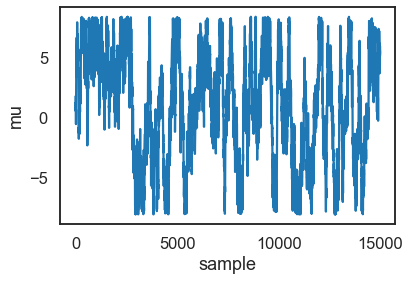

In [13]:
posterior = sampler(data,samples=15000, mu_init = 1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu')

This is usually called the trace. To now get an approximation of the posterior (the reason why we're doing this), we simply take the histogram of this trace. Its important to keep in mind that although this similar to the data we sampled above to fit the model, the two are completely seperate. THe below plot represents our __belief__ in `mu`. In this case it just happens to also be normal but for a different model, it could have a completely different shape than the likelihood or prior. 

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


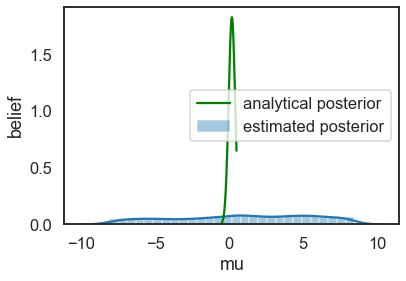

In [14]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytical posterior')
_=ax.set(xlabel='mu', ylabel='belief');
ax.legend();

As you can see, by following the above procedure, we get samples from the same distribution as what we derived analytically.

### Proposal width
Above we set the proposal width to `0.5`. That turned out to be a pretty good value. In general you don't want the width to be too narrow because your sampling will be inefficient as it takes a long time to explore the whole parameter space and shows the typical random-walk behaviour:

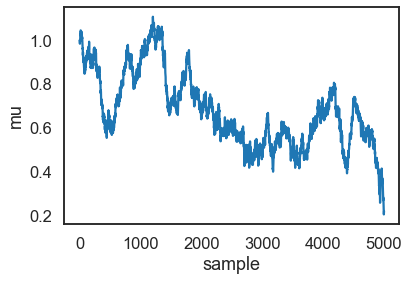

In [15]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width = .01)
fig, ax = plt.subplots()
ax.plot(posterior_small)
millaz = ax.set(xlabel='sample', ylabel='mu')

But you also don't want it to be so large that you never accept a jump:

<ipython-input-11-a7da279572f6>:22: RuntimeWarning: divide by zero encountered in double_scalars
  p_accept = p_proposal / p_current


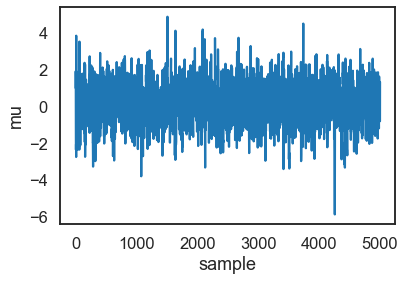

In [16]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu')
millaz = ax.set(xlabel='sample', ylabel='mu')

Note, however, that we are still sampling from our target posterior distribution here as guaranteed by the mathematical proof, just less efficiently:

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


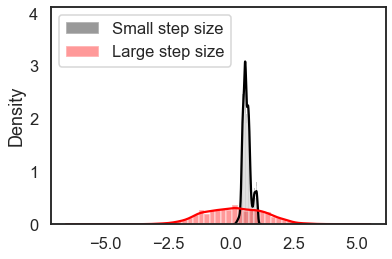

In [17]:
sns.distplot(posterior_small[1000:], label='Small step size', color = 'k')
sns.distplot(posterior_large[1000:], label='Large step size', color = 'r')
millaz = plt.legend()

With more samples this will eventally look like the true posterior. The key is that we want our samples to be independent of each other which clearly isn't the case here. Thus, one common metric to evaluate the efficiency of our sampler is the autocorrelation -- i.e. how correlated a sample `i` is to sample `i-1, 1-2, etc`

IndexError: tuple index out of range

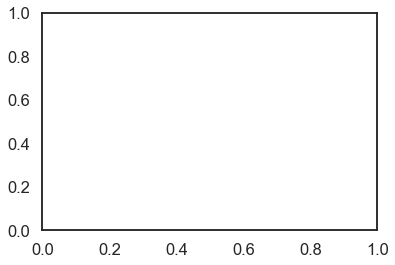

In [18]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

Obviously we want to have a smart way of figuring out the right step width automatically. ONe common method is to eep adjusting the proposal width so that roughly 50% proposals are rejected.

## Extending to more complex models
Now you can easily inagine that we could also add a `sigma` parameter for the standard -deviation and follow the same procedure for this second parameter. In that case, we would bbe generating proposals for `mu` and `sigma` but the algorithm logic would be nearly identical. Or, we could have data from a very different distribution like a Binomial and still use the same algoorithm and get teh correct posterior. That's pretty cool and a huge benefit of probabilistic programming: Just define the model you want and let MCMC take care of the inference.

For example, the below model can be written in `PyMC3` quite easily. Below we also use the Metropolis sampler (which automatically tunes the proposal width) and see that we get identical results. Play around and change distibutions.

In [19]:
import pymc3 as pm

with pm.model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)

    step = pm.Metropolis()
    trace = pm.sample(15000, step)

sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler')
sns.dostplot(posterior[500:], label = 'Hand-written sampler')
plt.legend()

TypeError: 'module' object is not callable

## Conclusions

We glossed over a lot of detail which is certainly important but there are many other posts that deal with that. Here, we really wanted to communicate the idea of MCMC and the Metropolis sampler. Hopefully you will have gathered some intuition which will equip you to read one of the more technical introductions to this topic.

Other, more fancy, MCMC algorithms like Hamiltonian Monte Carlo actually work very similar to this, they are just much more clever in proposing where to jump next.